# Availability of AirBnB Listings

In this notebook the AirBnB listings from Seattle from 2016 are used to analyse the availability of homes for the next 365 days. Firstly, the data and datatypes are inspected. Secondly, the data is processed and statistics are calculate describing the availability of the listings.

In [55]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# read in the calendar of the listings from the csv-file
df_list = pd.read_csv('./listings.csv')
df_list.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [56]:
# have a look which columns are present
df_list.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [57]:
# interesting is the availability for the entire year (availability_365), host_id, property_type, room_type, accommodates 
df_list_red = df_list[["id", "host_id", "availability_365", "property_type", "room_type", "accommodates"]]
df_list_red.head()

,id,host_id,availability_365,property_type,room_type,accommodates
0,241032,956883,346,Apartment,Entire home/apt,4
1,953595,5177328,291,Apartment,Entire home/apt,4
2,3308979,16708587,220,House,Entire home/apt,11
3,7421966,9851441,143,Apartment,Entire home/apt,3
4,278830,1452570,365,House,Entire home/apt,6


In [58]:
# look at the data types
df_list_red.dtypes

id                   int64
host_id              int64
availability_365     int64
property_type       object
room_type           object
accommodates         int64
dtype: object

In [59]:
# are there columns with only nan values
df_list_red.isnull().mean()

id                  0.000000
host_id             0.000000
availability_365    0.000000
property_type       0.000262
room_type           0.000000
accommodates        0.000000
dtype: float64

In [60]:
# how many rows does the dataframe have
num_rows = df_list_red.shape[0]
print("The reduced dataframe contains {} number of rows.".format(num_rows))

The reduced dataframe contains 3818 number of rows.


In [61]:
# and how many different listings
val_count = df_list_red["id"].value_counts()
num_listings = len(val_count)
print("There are {} different listings in Seattle.".format(num_listings))

There are 3818 different listings in Seattle.


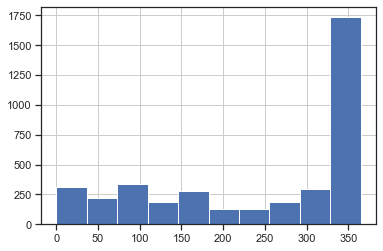

In [62]:
# create a fast/first overview about the availability for the next 365 days
avail_per_list = df_list_red["availability_365"]
avail_per_list.hist()

In [63]:
def plot_availability(availability_per_listing, title=None):
    """
    Creates a histogram of the availability and a normalized cumulative sum of the availabilities.
    
    INPUT
    availability_per_listing - Pandas series with the availability in days for each listing
    title - Name of the title for the graph
    
    OUTPUT
    base - x-values of the normalized cumulative sum of availabilities    
    cumulative - Normalized cumulative sum of availabilities for data points along the x-axis
    """
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Days available per listing')
    ax1.set_ylabel('listings')
    hist_vals = ax1.hist(availability_per_listing, zorder=1)
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()  # instantiate a second axis that shares the same x-axis
    # evaluate the histogram
    values, base = np.histogram(availability_per_listing, bins=10)
    #evaluate the cumulative
    cumulative = np.cumsum(values)
    cumulative = cumulative / len(availability_per_listing)
    color = 'tab:orange'
    ax2.set_ylabel('Proportion of listings')  #color=color we already handled the x-label with ax1
    ax2.plot(base[:-1], cumulative, color=color, zorder=2)
    ax2.tick_params(axis='y', labelcolor=color) 
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.title(title)
    plt.show()

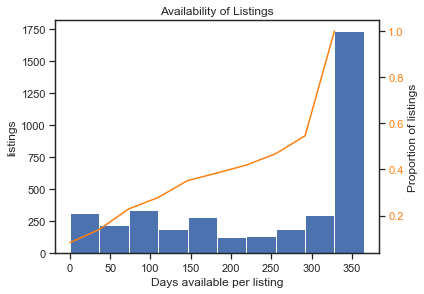

In [64]:
plot_availability(avail_per_list, "Availability of Listings")

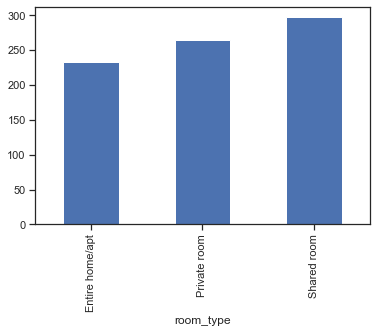

In [65]:
# how does the availability differ for the room types
avail_per_type = df_list_red.groupby("room_type").mean()
avail_per_type["availability_365"].plot(kind="bar")
plt.show()

In [66]:
# illustrate the deviation to the mean value
mean_availability = np.mean(avail_per_type["availability_365"])
avail_per_type["diff_to_mean"] = avail_per_type["availability_365"] - mean_availability # difference to mean
avail_per_type = avail_per_type.drop(["id", "host_id", "accommodates"], axis=1)
avail_per_type.style.bar(subset=["diff_to_mean"], align='mid', color=['#d65f5f', '#5fba7d'])

,availability_365,diff_to_mean
room_type,,
Entire home/apt,233.457,-31.4922
Private room,264.28,-0.669356
Shared room,297.111,32.1616


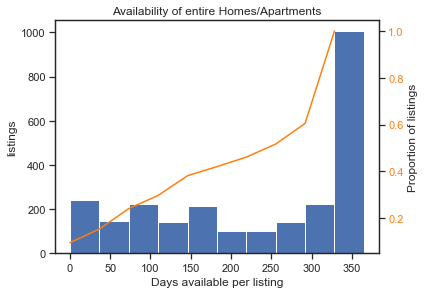

In [67]:
# closer look at the entire apartments / homes
df_entire = df_list_red[df_list_red["room_type"] == "Entire home/apt"]
avail_apart_house = df_entire["availability_365"]
plot_availability(avail_apart_house, title="Availability of entire Homes/Apartments")

In [68]:
# dataframe/availability for private and shared rooms
df_rooms = df_list.query("room_type == 'Private room' | room_type == 'Shared room'")
df_rooms.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
5,5956968,https://www.airbnb.com/rooms/5956968,20160104002432,2016-01-04,Private unit in a 1920s mansion,We're renting out a small private unit of one ...,If you include a bit of your background in you...,We're renting out a small private unit of one ...,none,This part of Queen Anne has wonderful views an...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,1,2.45
6,1909058,https://www.airbnb.com/rooms/1909058,20160104002432,2016-01-04,Queen Anne Private Bed and Bath,Enjoy a quiet stay in our comfortable 1915 Cra...,Enjoy a quiet stay in our comfortable 1915 Cra...,Enjoy a quiet stay in our comfortable 1915 Cra...,none,"Close restaurants, coffee shops and grocery st...",...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,1,2.46
7,856550,https://www.airbnb.com/rooms/856550,20160104002432,2016-01-04,Tiny Garden cabin on Queen Anne,"Our tiny cabin is private , very quiet and com...","This cabin was built with Airbnb in mind, Que...","Our tiny cabin is private , very quiet and com...",none,We are centrally located between Downtown and ...,...,10.0,f,NaN,WASHINGTON,f,strict,t,t,5,4.73
8,4948745,https://www.airbnb.com/rooms/4948745,20160104002432,2016-01-04,Urban Charm || Downtown || Views,"Nestled in the heart of the city, this space i...","Located in the heart of the city, this space i...","Nestled in the heart of the city, this space i...",none,Walking Score: 92 4 blocks from Kerry Park Fam...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,1,1.22
16,3245876,https://www.airbnb.com/rooms/3245876,20160104002432,2016-01-04,Park Life in Lower Queen Anne,Master bedroom suite with 1/4 bath & kitchenet...,**PLEASE MAKE SURE TO READ ALL INFO BEFORE BOO...,Master bedroom suite with 1/4 bath & kitchenet...,none,Lower Queen Anne is amazing - you can walk to ...,...,9.0,f,NaN,WASHINGTON,f,moderate,f,f,1,4.55


In [72]:
high_availability = 60 # days according to http://insideairbnb.com/seattle/
# number of private and shared rooms with low availability
rooms_low_avail = df_rooms[df_rooms["availability_365"] < high_availability]["availability_365"].count()
print("Fraction of shared/private rooms with low availability is {}.".format(round(rooms_low_avail/df_rooms.shape[0], 2)))

Fraction of shared/private rooms with low availability is 0.09


In [70]:
listings_entire = df_entire.shape[0] # number of listings which are entire homes/apartments
portion_entire = round((listings_entire / num_listings) * 100, 2)
print("{} listings are entire homes or apartments in Seattle. This corresponds to {} % of all listings.".format(listings_entire, portion_entire))
print("Only {} % of the listings are private or shared rooms.".format(100 - portion_entire))

2541 listings are entire homes or apartments in Seattle. This corresponds to 66.55 % of all listings.
Only 33.45 % of the listings are private or shared rooms.


In [75]:
# how many of these entire apartments/homes have a high availability
entire_list_high = np.sum(df_entire["availability_365"] > high_availability)
print("Fraction of entire apartments/homes with high availability: {}.".format(round(entire_list_high / listings_entire, 2)))

Fraction of entire apartments/homes with high availability: 0.87.


In [76]:
print("Fraction of entire apartments/homes with high availability from all listings: {}".format(round(entire_list_high / num_listings, 2)))

Fraction of entire apartments/homes with high availability from all listings: 0.58


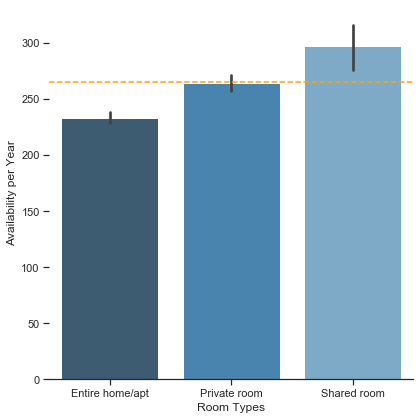

In [77]:
# improved bar chart for the availability grouped by room types
sns.set(style="ticks")
g = sns.catplot(x="room_type", y="availability_365", data=df_list_red,
                height=6, kind="bar", palette="Blues_d")
g.axes[0][0].axhline(mean_availability, ls='--', color="orange")

g.despine(left=True)
g.set_ylabels("Availability per Year")
g.set_xlabels("Room Types")